In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import lasagne
from lasagne.layers import *

#### Utility to generate our two dimensional data

In [2]:
def generate_data(n=1, sz=500):
    mean = np.random.uniform(high=4, size=(2,))
    cov = np.eye(2)
    ans = np.random.multivariate_normal(mean, cov, np.random.randint(10, high=sz))
    for _ in range(n - 1):
        mean = np.random.exponential(scale=2, size=(2,))
        cnt = np.random.randint(10, high=sz)
        ans = np.concatenate((ans, np.random.multivariate_normal(mean, cov, cnt)))
    return ans

In [3]:
data = generate_data(5, 500)

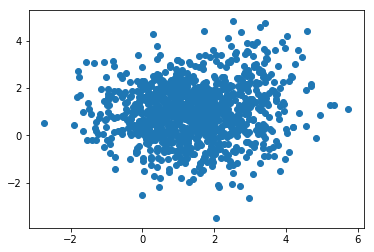

(1037, 2)


In [4]:
xd, yd = data.T
plt.scatter(xd, yd)
plt.show()
print(data.shape)

In [5]:
g_in = T.matrix('g_in')
d_in = T.matrix('d_in')

In [6]:
g_l = InputLayer([None, 1])
g_l = DenseLayer(g_l, 50, nonlinearity=lasagne.nonlinearities.rectify)
g_l = DropoutLayer(g_l, p=0.5)
g_l = DenseLayer(g_l, 50, nonlinearity=lasagne.nonlinearities.elu)
g_l = DenseLayer(g_l, 50, nonlinearity=lasagne.nonlinearities.tanh)
g_l = DenseLayer(g_l, 2, nonlinearity=lasagne.nonlinearities.linear)
g_weights = lasagne.layers.get_all_params(g_l)
print(g_weights)

[W, b, W, b, W, b, W, b]


In [7]:
g_out = lasagne.layers.get_output(g_l, g_in)
G = theano.function([g_in], g_out)

In [8]:
d_l = InputLayer([None, 2])
d_l = DenseLayer(d_l, 50, nonlinearity=lasagne.nonlinearities.rectify)
d_l = DenseLayer(d_l, 50, nonlinearity=lasagne.nonlinearities.tanh)
d_l = DenseLayer(d_l, 50, nonlinearity=lasagne.nonlinearities.rectify)
d_l = DenseLayer(d_l, 1, nonlinearity=lasagne.nonlinearities.sigmoid)
d_weights = lasagne.layers.get_all_params(d_l)
print(d_weights)

[W, b, W, b, W, b, W, b]


In [9]:
d_outD = lasagne.layers.get_output(d_l, d_in)
d_outG = lasagne.layers.get_output(d_l, g_out)
D = theano.function([d_in], d_outD)

In [10]:
loss_g = (T.log(d_outG)).mean()
loss_d = (T.log(d_outD) + T.log(1 - d_outG)).mean()

In [11]:
lr_d = theano.shared(0.5)
lr_g = theano.shared(0.5)

In [12]:
train_d = theano.function([g_in, d_in], updates=lasagne.updates.adadelta(-loss_d, d_weights, learning_rate=lr_d))

In [13]:
train_g = theano.function([g_in], updates=lasagne.updates.adadelta(-loss_g, g_weights, learning_rate=lr_g), outputs=g_out)

In [14]:
from IPython import display

def train(data, n_epoch=100, k=10, m=10):
    for _ in range(n_epoch):
        for _ in range(k):
            noise = np.random.normal(size=(m, 1))
            samples = np.random.permutation(data)[:m]
            train_d(noise, samples)
        noise = np.random.normal(size=(m, 1))
        dt = train_g(noise)
        plt.scatter(xd, yd)
        x, y = dt.T
        plt.scatter(x, y)
        display.clear_output(wait=True)
        plt.show()

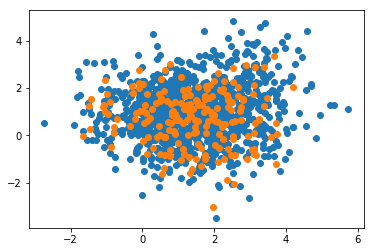

In [15]:
train(data, n_epoch=300, k=2, m=200)

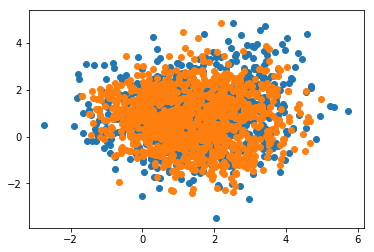

(1000,) (1000,)


In [16]:
plt.scatter(xd, yd)
r = np.random.normal(size=(1000, 1))
f = G(r)
x, y = f.T
plt.scatter(x, y)
plt.show()
print(x.shape, y.shape)

In [17]:
bins = 50

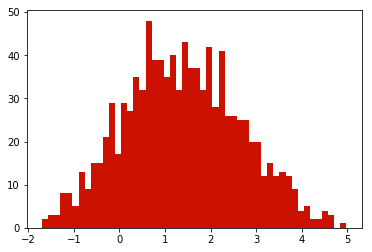

In [18]:
#fake data x
plt.hist(x, bins, color='#CC1100')
plt.show()

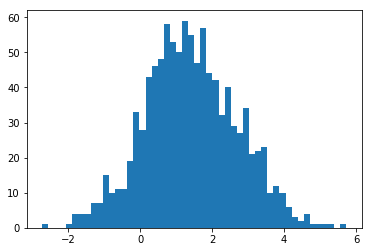

In [19]:
# Real data x
plt.hist(xd, bins)
plt.show()

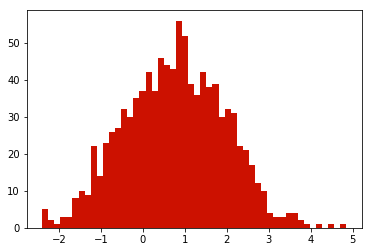

In [20]:
# fake data y
plt.hist(y, bins, color='#CC1100')
plt.show()

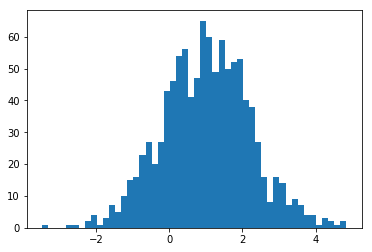

In [21]:
# real data y
plt.hist(yd, bins)
plt.show()

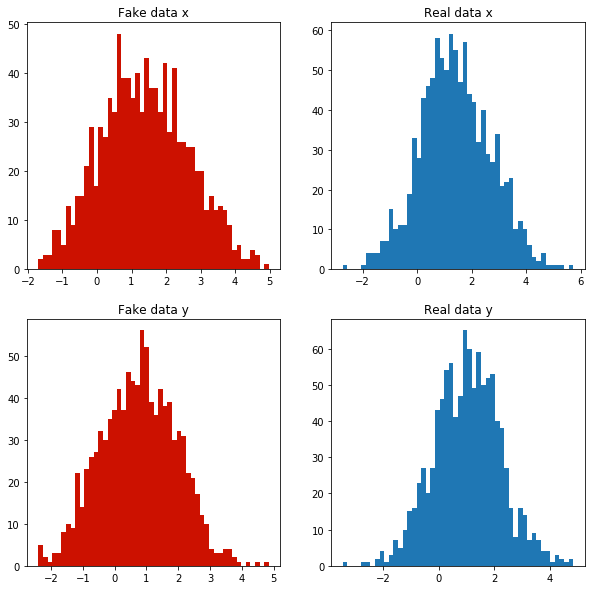

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.subplot2grid((2, 2), (0, 0))
plt.hist(x, bins, color='#CC1100')
plt.title('Fake data x')
plt.subplot2grid((2, 2), (0, 1))
plt.hist(xd, bins)
plt.title('Real data x')
plt.subplot2grid((2, 2), (1, 0))
plt.hist(y, bins, color='#CC1100')
plt.title('Fake data y')
plt.subplot2grid((2, 2), (1, 1))
plt.hist(yd, bins)
plt.title('Real data y')
plt.show()